In [1]:
from custom_clss_and_fncs import * 
from cobra.io import load_json_model

model = load_json_model("models/GEM_Recon2_thermocurated_redHUMAN.json")

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [2]:
import pandas as pd

grafo_nx = cobra_a_networkx(model)
s = pd.read_parquet("results/data/flux_samples.parquet.gzip")#.loc[0:100,:]


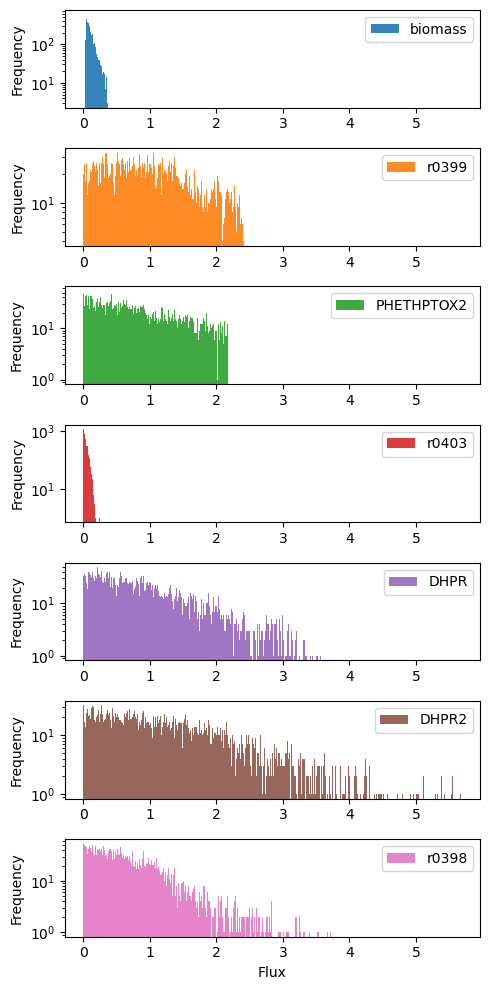

In [3]:
import matplotlib.pyplot as plt

rxn_list = ['biomass', 'r0399', 'PHETHPTOX2', 'r0403', 'DHPR', 'DHPR2', 'r0398']

flux_samples = abs(s[ (s.PHETHPTOX2 < np.percentile(s.PHETHPTOX2, 90)) &
                   (s.r0399 < np.percentile(s.r0399, 90)) ])# &
                   #(s.biomass < np.percentile(s.biomass, 90)) ]


flux_samples[rxn_list].plot.hist(bins=500, alpha=0.9, figsize=(5,10), subplots=True, sharey=False, 
                      sharex=False, logy = True, ylabel = ['', '', ''], grid=False)
plt.xlabel('Flux') 
#plt.ylabel(None)
#plt.ylabel("common Y")
#fig.supylabel('common y label')
plt.tight_layout()
plt.show()

In [4]:

import pickle


nx_G, pyg_graph, producto_idx = set_flux_attributes_in_nx(flux_samples, grafo_nx, target_node = 'r0399')


nx.write_gpickle(nx_G, "results/data/nx_G.gpickle")

list_of_graphs = generate_graph_list(pyg_graph, producto_idx)

with open('results/data/lista_de_grafos.pkl', 'wb') as file:
      
    pickle.dump(list_of_graphs, file)


In [63]:


Train_graphs, Test_graphs = train_test_split(
            list_of_graphs,test_size=0.35,shuffle=True)


out_channels = 9
hidden_dim   = 9
num_layers   = 3
n_nodes      = pyg_graph.num_nodes
loss_fun  = torch.nn.MSELoss()
modelo = regresor_GIN(target_node_idx = producto_idx,n_nodes = n_nodes, num_features = 1, 
                      out_channels = out_channels, hidden_dim =hidden_dim, 
                      num_layers=num_layers, dropout=.1).to('cpu') 

optimizer = torch.optim.Adam(modelo.parameters(),)

batch_size   = 10
num_samples  = 400
epochs       = 100

n_nodes      = pyg_graph.num_nodes
train_loader = make_loader(Train_graphs, batch_size,num_samples)
test_loader  = make_loader(Test_graphs, batch_size, num_samples = 200)
best_eval_weights, check_seen_y  = train_and_evaluate(optimizer,loss_fun, modelo, train_loader,test_loader,save_state_dict = True,
                                       epochs = epochs, batch_size=batch_size, verbose = True)

  1%|          | 1/100 [00:00<01:23,  1.18it/s]

NEW best min_total_loss_val 8.476057633757591 epoch: 0
state_dict_best_evaluated_model.pth overwritten


  2%|▏         | 2/100 [00:01<01:23,  1.17it/s]

NEW best min_total_loss_val 7.327387746423483 epoch: 1
state_dict_best_evaluated_model.pth overwritten


  8%|▊         | 8/100 [00:06<01:15,  1.22it/s]

NEW best min_total_loss_val 7.323704391717911 epoch: 7
state_dict_best_evaluated_model.pth overwritten


 11%|█         | 11/100 [00:09<01:13,  1.21it/s]

NEW best min_total_loss_val 7.153155609965324 epoch: 10
state_dict_best_evaluated_model.pth overwritten


 54%|█████▍    | 54/100 [00:44<00:38,  1.19it/s]

NEW best min_total_loss_val 6.875336691737175 epoch: 53
state_dict_best_evaluated_model.pth overwritten


100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


<AxesSubplot:>

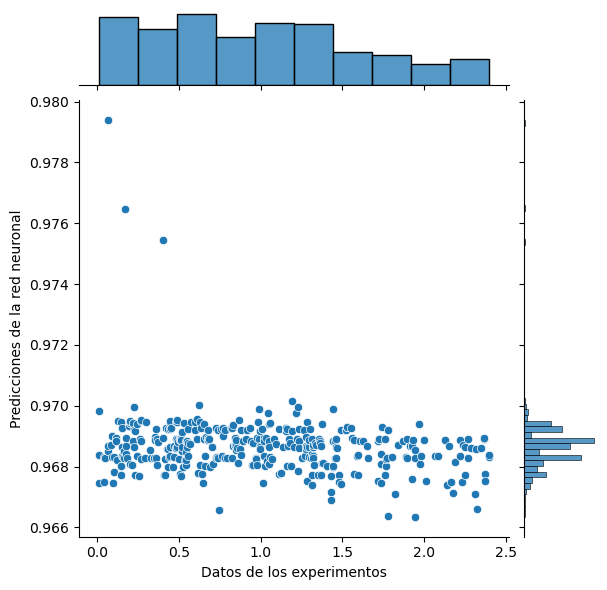

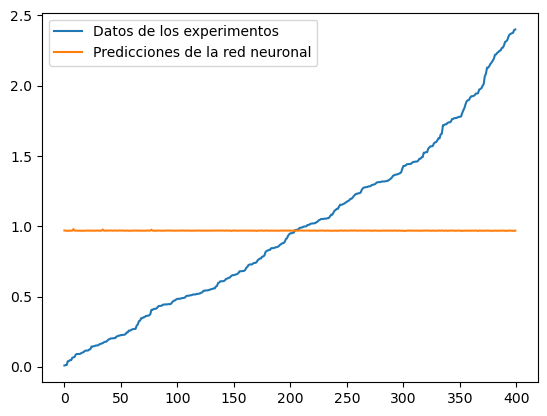

In [64]:
import seaborn as sns
#pd.Series(check_seen_y).sort_values(inplace=False).reset_index(drop=True).plot()
#modelo.load_state_dict(torch.load("results/state_dicts/state_dict_best_evaluated_model.pth"))
modelo.load_state_dict(best_eval_weights)

predictions: list = []
true_values: list = []
modelo.eval()
for data in train_loader:
    data.to('cuda')
    prediction = modelo(data.x, data.edge_index, batch_size)
    predictions.extend(prediction.squeeze().tolist())
    true_values.extend(data.y.squeeze().tolist())
    
sorted_idxs = np.argsort(true_values)

evaluation = pd.DataFrame(
        {'Datos de los experimentos': [true_values[i] for i in sorted_idxs],
        'Predicciones de la red neuronal':[predictions[i] for i in sorted_idxs]}
    ) 
sns.jointplot(x=evaluation.iloc[:,0], y = evaluation.iloc[:,1])

evaluation.plot()
